In [ ]:
!pip install quantile-forest

In [ ]:
!pip install dill

In [ ]:
!pip install lightgbm

In [ ]:
!pip install ngboost

In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from joblib import Parallel, delayed
import seaborn as sns
sns.set_style('whitegrid')
import sys
sys.path.append('..')
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_pinball_loss
%load_ext autoreload
%autoreload 2

In [2]:
from src import tqf
from src.qmem import energy_distance, energy_score

# Data preparation

In [2]:
X, y = fetch_california_housing(return_X_y=True, as_frame=True)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
df = pd.concat([X, y], axis=1)
del X, y
df = df.astype(np.float32)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.880001,-122.230003,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.860001,-122.220001,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.849998,-122.239998,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.849998,-122.250000,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.849998,-122.250000,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.480000,-121.089996,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.490002,-121.209999,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.430000,-121.220001,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.430000,-121.320000,0.847


In [4]:
df['MedHouseVal'].sort_values().values

array([0.14999, 0.14999, 0.14999, ..., 5.00001, 5.00001, 5.00001],
      shape=(20640,), dtype=float32)

In [5]:
df['HouseAge'].sort_values().values

array([ 1.,  1.,  1., ..., 52., 52., 52.], shape=(20640,), dtype=float32)

In [6]:
X = df.drop(['Longitude', 'Latitude'], axis=1)
# Normalization of X: useful to boost performance of bayesian ridge (viz. approximate GP with RFF)
X = QuantileTransformer(output_distribution='normal').set_output(transform='pandas').fit_transform(X)
Y = df[['Longitude', 'Latitude']]
Y = QuantileTransformer(output_distribution='uniform', random_state=0).set_output(transform='pandas').fit_transform(Y)
X.shape, Y.shape

((20640, 7), (20640, 2))

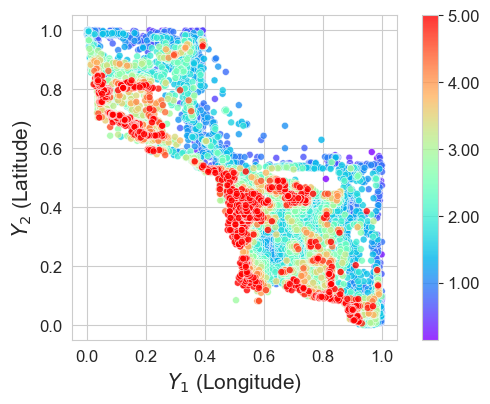

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
idxes = np.argsort(df['MedHouseVal'])
sns.scatterplot(Y.iloc[idxes], x='Longitude', y='Latitude', s=25, alpha=0.8, 
                c=df['MedHouseVal'].iloc[idxes], cmap='rainbow', ax=ax)
ax.set_xlabel(r'$Y_1$ (Longitude)', fontsize=15)
ax.set_ylabel(r'$Y_2$ (Latitude)', fontsize=15)
plt.tick_params(labelsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
im = ax.collections[0]
cbar = fig.colorbar(im, cax=cax, format='%.2f')
cbar.ax.tick_params(labelsize=12)
ax.set_aspect('equal')
plt.tight_layout()
# plt.savefig('fg_housing.pdf', dpi=400)

In [18]:
np.corrcoef(X['AveOccup'].values, Y.iloc[:, 0].values), np.corrcoef(X['AveOccup'].values, Y.iloc[:, 1].values)

(array([[1.        , 0.16891138],
        [0.16891138, 1.        ]]),
 array([[ 1.        , -0.13591697],
        [-0.13591697,  1.        ]]))

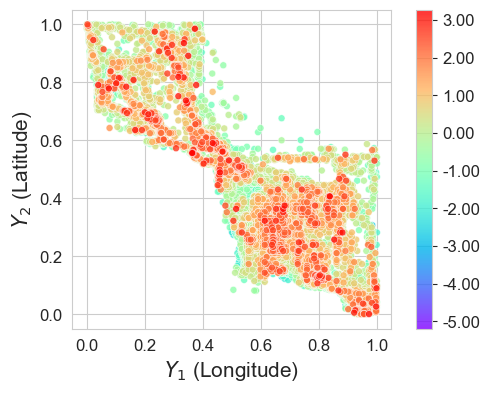

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
idxes = np.argsort(X['AveOccup'])[:-1]
sns.scatterplot(Y.iloc[idxes], x='Longitude', y='Latitude', s=25, alpha=0.8, 
                c=X['AveOccup'].iloc[idxes], cmap='rainbow', ax=ax)
ax.set_xlabel(r'$Y_1$ (Longitude)', fontsize=15)
ax.set_ylabel(r'$Y_2$ (Latitude)', fontsize=15)
plt.tick_params(labelsize=12)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
im = ax.collections[0]
cbar = fig.colorbar(im, cax=cax, format='%.2f')
cbar.ax.tick_params(labelsize=12)
ax.set_aspect('equal')
plt.tight_layout()
# plt.savefig('fg_housing_2.pdf', dpi=400)

In [9]:
n_cv = 10
cv_indices_list = list(KFold(n_splits=n_cv, shuffle=True, random_state=0).split(X))
cv_indices_list[0]

(array([    0,     1,     2, ..., 20637, 20638, 20639], shape=(18576,)),
 array([    7,    12,    16, ..., 20626, 20629, 20630], shape=(2064,)))

# GP

In [ ]:
def run_GP(C: int, n_jobs: int):

    assert C in range(n_cv)
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X.values[trainval_idx]
    Y_tv = Y.values[trainval_idx]
    X_test = X.values[test_idx]
    Y_test = Y.values[test_idx]
    from sklearn.kernel_approximation import RBFSampler
    from sklearn.linear_model import BayesianRidge
    trans = RBFSampler(gamma='scale', n_components=1000, random_state=C)
    X_tv_r = trans.fit_transform(X_tv)
    X_test_r = trans.transform(X_test)
    
    Y_pred = []
    Y_std = []
    for k in range(Y.shape[1]):
    
        model = BayesianRidge()
        model.fit(X_tv_r, Y_tv[:, k])
        y_pred, y_std = model.predict(X_test_r, return_std=True)
        Y_pred.append(y_pred)
        Y_std.append(y_std)
    
    Y_pred = np.array(Y_pred).T
    Y_std = np.array(Y_std).T

    # NLL and energy score
    from scipy.stats import multivariate_normal

    def aux(j: int):
        
        mn = multivariate_normal(mean=Y_pred[j], cov=np.diag(Y_std[j] ** 2))
        _nll = - mn.logpdf(Y_test[j]).item()
        _es = energy_score(y=Y_test[j], zs=mn.rvs(size=1000, random_state=C + j))
        
        return _nll, _es

    from joblib import Parallel, delayed
    res = Parallel(n_jobs=n_jobs)(delayed(aux)(j) for j in range(len(Y_test)))
    nll = np.array([o[0] for o in res])
    es = np.array([o[1] for o in res])

    return Y_test, (Y_pred, Y_std), (nll, es)

In [ ]:
%%time
out_all = [run_GP(C=C, n_jobs=5) for C in range(n_cv)]

CPU times: user 3min 12s, sys: 40.3 s, total: 3min 52s
Wall time: 17min 57s


In [ ]:
import dill
with open('housing_gp_cv.pkl', 'wb') as f:
    dill.dump(out_all, f)

In [45]:
import dill
with open('housing_gp_cv.pkl', 'rb') as f:
    out_all = dill.load(f)

In [46]:
from sklearn.metrics import r2_score
gp_r2 = np.array([r2_score(y_true=out_all[C][0], 
                  y_pred=out_all[C][1][0], multioutput='raw_values') for C in range(n_cv)])
gp_r2

array([[0.1477511 , 0.22263092],
       [0.15588635, 0.23955   ],
       [0.13618827, 0.22333628],
       [0.17114192, 0.23788267],
       [0.15361887, 0.21863264],
       [0.14007807, 0.21772498],
       [0.16894591, 0.23610324],
       [0.16466063, 0.23922193],
       [0.16187656, 0.22880346],
       [0.15450352, 0.20169634]], dtype=float32)

In [44]:
gp_r2.mean(axis=0), gp_r2.std(axis=0)

(array([0.15546513, 0.22655825], dtype=float32),
 array([0.01107038, 0.01156852], dtype=float32))

In [46]:
gp_r2.mean(axis=1)

array([0.185191  , 0.19771817, 0.17976227, 0.2045123 , 0.18612576,
       0.17890152, 0.20252457, 0.20194128, 0.19534001, 0.17809993],
      dtype=float32)

In [47]:
gp_r2.mean(axis=1).mean(), gp_r2.mean(axis=1).std()

(np.float32(0.1910117), np.float32(0.009978236))

In [47]:
gp_nll = np.array([out_all[C][2][0] for C in range(n_cv)])
gp_es = np.array([out_all[C][2][1] for C in range(n_cv)])
gp_nll.shape, gp_es.shape

((10, 2064), (10, 2064))

In [52]:
gp_nll.mean(), gp_nll.std()

(np.float64(0.14231670939414848), np.float64(1.0309732910651213))

In [49]:
gp_es.mean(), gp_es.std(), np.median(gp_es)

(0.22945176498439712, 0.1223019470762858, 0.1964615548201491)

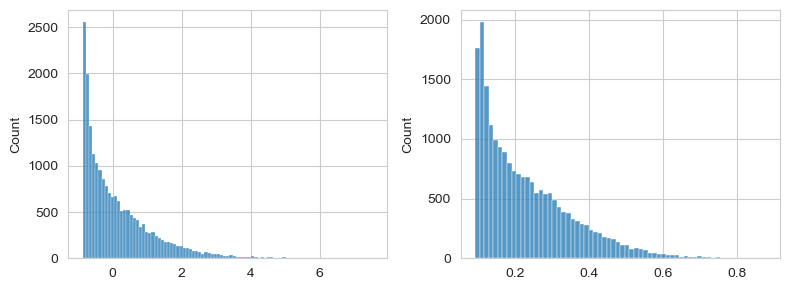

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.histplot(gp_nll.ravel(), ax=ax[0])
sns.histplot(gp_es.ravel(), ax=ax[1])
plt.tight_layout()

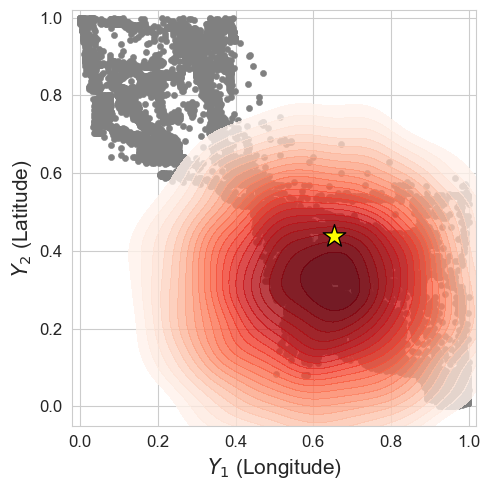

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(Y, x='Longitude', y='Latitude', s=20, color=(0.5, 0.5, 0.5), ax=ax, edgecolor=None)

IDX = 400
out = out_all[5]
# ground truth
plt.scatter(out[0][IDX, 0], out[0][IDX, 1], marker='*', s=290, c='yellow', 
            edgecolor='k', zorder=3)

from scipy.stats import multivariate_normal
mn = multivariate_normal(mean=out[1][0][IDX], cov=np.diag(out[1][1][IDX])**2)
mn_rvs = mn.rvs(size=25000, random_state=20)
sns.kdeplot(data=pd.DataFrame(mn_rvs), x=0, y=1, cmap='Reds', levels=22, fill=True, alpha=0.8, thresh=0.2)

ax.set_xlabel(r'$Y_1$ (Longitude)', fontsize=15)
ax.set_ylabel(r'$Y_2$ (Latitude)', fontsize=15)
ax.set_xlim(-0.02, 1.02); ax.set_ylim(-0.05, 1.02)
plt.tick_params(labelsize=12)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
# plt.savefig('fg_housing_gp.pdf', dpi=400)

# RF

In [92]:
def para_search_RF(C: int):

    assert C in range(n_cv)
    trainval_idx, _ = cv_indices_list[C]
    X_tv = X.values[trainval_idx]
    Y_tv = Y.values[trainval_idx]

    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import r2_score

    for msl in [1, 5, 10, 20, 50, 100, 200, 300]:
        
        model = RandomForestRegressor(n_estimators=200, random_state=C, n_jobs=4,
                                      oob_score=True, min_samples_leaf=msl)
        model.fit(X_tv, Y_tv)
        Y_pred = model.oob_prediction_
        R2 = r2_score(y_true=Y_tv, y_pred=Y_pred)
        print(f"min_samples_leaf: {msl} \t R2: {R2}")

In [93]:
%%time
para_search_RF(C=0)

min_samples_leaf: 1 	 R2: 0.18930201050010115
min_samples_leaf: 5 	 R2: 0.19656890706128627
min_samples_leaf: 10 	 R2: 0.19697897901214395
min_samples_leaf: 20 	 R2: 0.19558817505462317
min_samples_leaf: 50 	 R2: 0.18655820228246267
min_samples_leaf: 100 	 R2: 0.1739568374028715
min_samples_leaf: 200 	 R2: 0.15581191135913963
min_samples_leaf: 300 	 R2: 0.14587530551959382
CPU times: total: 1min 38s
Wall time: 26.4 s


In [50]:
def run_RF(C: int, n_jobs: int, return_model: bool = False):

    assert C in range(n_cv)
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X.values[trainval_idx]
    Y_tv = Y.values[trainval_idx]
    X_test = X.values[test_idx]
    Y_test = Y.values[test_idx]

    from sklearn.ensemble import RandomForestRegressor    
    Y_pred = []
    msl = 10
    model = RandomForestRegressor(n_estimators=200, random_state=C, n_jobs=n_jobs, 
                                  min_samples_leaf=msl)
    model.fit(X_tv, Y_tv)
    Y_pred = model.predict(X_test)
    if not return_model:
        return Y_test, Y_pred
    else:
        return Y_test, Y_pred, (model, X_test)

In [51]:
%%time
out_all = [run_RF(C=C, n_jobs=4) for C in range(n_cv)]

CPU times: user 4min 56s, sys: 705 ms, total: 4min 57s
Wall time: 1min 15s


In [52]:
from sklearn.metrics import r2_score
rf_r2 = np.array([r2_score(y_true=out_all[C][0], 
                  y_pred=out_all[C][1], multioutput='raw_values') for C in range(n_cv)])
rf_r2

array([[0.16629206, 0.24137466],
       [0.17471351, 0.25003296],
       [0.15827361, 0.24088391],
       [0.18533543, 0.24316631],
       [0.15948915, 0.22569383],
       [0.16053503, 0.23724678],
       [0.16073655, 0.23768558],
       [0.16649411, 0.24978161],
       [0.17096847, 0.23299353],
       [0.16712326, 0.21383921]])

In [99]:
rf_r2.mean(axis=0), rf_r2.std(axis=0)

(array([0.1669331 , 0.23720485]), array([0.00787621, 0.01050761]))

In [100]:
rf_r2.mean(axis=1)

array([0.20369424, 0.21234874, 0.19947987, 0.21419895, 0.19259208,
       0.19903876, 0.19914223, 0.20830727, 0.20175029, 0.19013731])

In [102]:
rf_r2.mean(axis=1).mean(), rf_r2.mean(axis=1).std()

(np.float64(0.20206897553685882), np.float64(0.007423590610961978))

In [53]:
%%time
rf_es = np.array([[energy_score(y=y, zs=np.atleast_2d(z)) 
                   for (y, z) in zip(out_all[C][0], out_all[C][1])] for C in range(n_cv)])
rf_es.shape

CPU times: user 333 ms, sys: 16.2 ms, total: 350 ms
Wall time: 332 ms


(10, 2064)

In [54]:
rf_es.mean(), rf_es.std(), np.median(rf_es)

(0.31143725812132134, 0.1906364001869601, 0.2877927238363285)

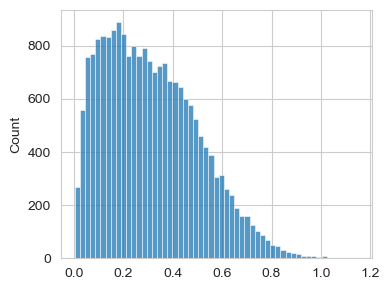

In [109]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(rf_es.ravel(), ax=ax)
plt.tight_layout()

In [11]:
%%time
out_rf = [run_RF(C=C, n_jobs=4, return_model=True) for C in range(n_cv)]

CPU times: total: 4min 39s
Wall time: 1min 12s


In [12]:
import shap
from shap import TreeExplainer

In [18]:
%%time
shap_vals = TreeExplainer(model=out_rf[5][2][0], feature_names=X.columns).shap_values(out_rf[5][2][1][:300])
shap_vals.shape

CPU times: total: 18 s
Wall time: 18.2 s


(300, 7, 2)

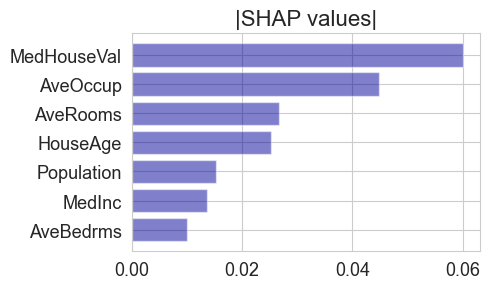

In [ ]:
plt.figure(figsize=(5, 3))
fi_mean = np.abs(shap_vals).transpose([1, 0, 2]).reshape(7, 600).mean(axis=1)
fi_idx = np.argsort(fi_mean)
plt.barh(range(7), fi_mean[fi_idx], tick_label=X.columns[fi_idx], color=(0., 0.0, 0.6), alpha=0.5)
plt.tick_params(labelsize=13)
plt.title('|SHAP values|', fontsize=16)
plt.tight_layout()
# plt.savefig('fg_housing_rf_shap.pdf', dpi=400)

# LightGBM

In [ ]:
def para_search_LGBM(C: int):

    assert C in range(n_cv)
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X.values[trainval_idx].copy()
    Y_tv = Y.values[trainval_idx].copy()
    from sklearn.model_selection import train_test_split
    X_train, X_val, Y_train, Y_val = train_test_split(X_tv, Y_tv, test_size=len(test_idx), random_state=C)
    from lightgbm import LGBMRegressor, early_stopping

    lr_s = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
    msl_s = [1, 5, 10, 20, 50, 100, 200, 300]
    L2_s = []
    params_s = []
    
    for lr in lr_s:
        for msl in msl_s:

            L2 = []
            iters = []
            
            for k in range(Y.shape[1]):
                
                params = {'random_state': C, 'learning_rate': lr, 'verbosity': -1, 
                          'min_data_in_leaf': msl, 'num_leaves': 1000}
                model = LGBMRegressor(**params, n_estimators=10000)
                model.fit(pd.DataFrame(X_train, columns=X.columns), Y_train[:, k].copy(),
                          eval_set=[(X_val, Y_val[:, k].copy())],
                          callbacks=[early_stopping(stopping_rounds=20)])
                iters.append(model.best_iteration_)
                L2.append(model.best_score_['valid_0']['l2'].item())
            
            L2_s.append(np.mean(L2))
            params_s.append({'learning_rate': lr, 'min_data_in_leaf': msl, 'best_iteration': iters})

    best_idx = np.argmin(L2_s)
    result = (params_s[best_idx], {'l2 loss': L2_s[best_idx]})
    
    return result

In [151]:
%%time
para_LGBM_result = para_search_LGBM(C=0)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[333]	valid_0's l2: 0.0710693
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[472]	valid_0's l2: 0.0670196
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[303]	valid_0's l2: 0.0706479
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[327]	valid_0's l2: 0.0671263
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[321]	valid_0's l2: 0.0715798
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[320]	valid_0's l2: 0.0665866
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[449]	valid_0's l2: 0.070064
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[399]	valid_0's l2: 0.0

In [153]:
para_LGBM_result

({'learning_rate': 0.05, 'min_data_in_leaf': 50, 'best_iteration': [62, 51]},
 {'l2 loss': np.float64(0.06741967439806489)})

In [57]:
def run_LGBM(C: int):

    assert C in range(n_cv)
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X.values[trainval_idx].copy()
    Y_tv = Y.values[trainval_idx].copy()
    X_test = X.values[test_idx].copy()
    Y_test = Y.values[test_idx].copy()
    from lightgbm import LGBMRegressor, early_stopping
    lr = 0.05
    msl = 50
    best_iter = [62, 51]
    Y_pred = []
    
    for k in range(Y.shape[1]):
        
        params = {'random_state': C, 'learning_rate': lr, 'verbosity': -1, 
                  'min_data_in_leaf': msl, 'num_leaves': 1000}
        model = LGBMRegressor(**params, n_estimators=best_iter[k])
        model.fit(pd.DataFrame(X_tv, columns=X.columns), Y_tv[:, k].copy())
        y_pred = model.predict(pd.DataFrame(X_test))
        Y_pred.append(y_pred)
    
    Y_pred = np.array(Y_pred).T
    
    return Y_test, Y_pred

In [60]:
%%time
out_all = [run_LGBM(C=C) for C in range(n_cv)]

CPU times: user 38 s, sys: 1.12 s, total: 39.1 s
Wall time: 9.86 s


In [76]:
from sklearn.metrics import r2_score
lgbm_r2 = np.array([r2_score(y_true=out_all[C][0], y_pred=out_all[C][1], 
                             multioutput='raw_values') for C in range(n_cv)])
lgbm_r2

array([[0.14881193, 0.22969057],
       [0.16387484, 0.25306266],
       [0.14700755, 0.23349658],
       [0.18060384, 0.23842999],
       [0.15233865, 0.22276335],
       [0.14426308, 0.22529329],
       [0.1668383 , 0.23917395],
       [0.16293856, 0.24107854],
       [0.16381092, 0.21719715],
       [0.1617184 , 0.21844511]])

In [77]:
lgbm_r2.mean(axis=0), lgbm_r2.std(axis=0)

(array([0.15922061, 0.23186312]), array([0.01051977, 0.01076758]))

In [78]:
lgbm_r2.mean(axis=1)

array([0.18925125, 0.20846875, 0.19025207, 0.20951691, 0.187551  ,
       0.18477819, 0.20300613, 0.20200855, 0.19050403, 0.19008176])

In [79]:
lgbm_r2.mean(axis=1).mean(), lgbm_r2.mean(axis=1).std()

(0.1955418630519272, 0.008731533135844655)

In [80]:
%%time
lgbm_es = np.array([[energy_score(y=y, zs=np.atleast_2d(z)) 
                   for (y, z) in zip(out_all[C][0], out_all[C][1])] for C in range(n_cv)])
lgbm_es.shape

CPU times: user 341 ms, sys: 8.06 ms, total: 349 ms
Wall time: 330 ms


(10, 2064)

In [82]:
lgbm_es.mean(), lgbm_es.std(), np.median(lgbm_es)

(0.31430618894561413, 0.18882573989459356, 0.2923528909550096)

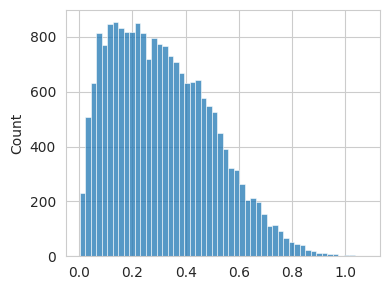

In [83]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(lgbm_es.ravel(), ax=ax)
plt.tight_layout()

# TQF

In [21]:
def approximate_ES_for_TQF(X_: np.ndarray | pd.DataFrame, Y_: np.ndarray | pd.DataFrame, predict_mean: bool, 
                           theta_s: np.ndarray | list, qs: np.ndarray | list, model: tqf.TQF, individual_es: bool = False) -> float:
    
    assert model.fitted
    assert X_.ndim == Y_.ndim == 2
    assert Y_.shape[1] == 2
    
    y_preds = model.y_scaler_1d.inverse_transform(
                  model.predict_q(
                      X_long=np.c_[
                          np.tile(X_, (len(theta_s), 1)), 
                          np.repeat([model.expand_v(v=[np.cos(theta), np.sin(theta)], n_rot=model.n_rot) for theta in theta_s], 
                                    len(X_), axis=0)
                      ],
                      qs=qs
                  ).reshape(-1, 1)
              ).reshape(len(X_) * len(theta_s), len(qs))
    
    # assume that y_scaler_whole is None
    y_trues = np.concatenate([Y_ @ np.array([np.cos(theta), np.sin(theta)]) for theta in theta_s])
    from scipy import special
    coef = lambda d: (d - 1) * 0.5 * np.sqrt(np.pi) * special.gamma((d - 1) / 2) / special.gamma(d / 2)
    
    if not individual_es:
        
        es = coef(2) * 2 * np.mean([mean_pinball_loss(y_pred=y_preds[:, i], y_true=y_trues, alpha=q) for i, q in enumerate(qs)])
    
    else:
        _yp = y_preds.reshape(len(theta_s), len(X_), len(qs)).transpose(1, 0, 2)
        _yt = y_trues.reshape(len(theta_s), len(X_)).T
        es = np.array([coef(2) * 2 * np.mean([mean_pinball_loss(y_pred=yp[:, i], y_true=yt, alpha=q) for i, q in enumerate(qs)]) 
                       for (yp, yt) in zip(_yp, _yt)])

    if not predict_mean:

        return es
    
    else:
        y_preds_mean = np.mean(y_preds, axis=1).reshape(len(theta_s), len(X_)).T
        assert y_preds_mean.shape == (len(X_), len(theta_s))
        projector = np.r_[[np.array([np.cos(theta), np.sin(theta)]) for theta in theta_s]]
        from sklearn.metrics import mean_squared_error

        def err(y: np.ndarray, ys: np.ndarray) -> float:
            
            assert y.shape == (2,) and ys.shape == (len(theta_s),)
            y_th = projector @ y

            return mean_squared_error(y_true=ys, y_pred=y_th)

        from scipy.optimize import minimize
        Y_mean_predictions = np.array([minimize(fun=lambda y: err(y, ys), x0=np.zeros(2), method='SLSQP').x for ys in y_preds_mean])
        assert Y_mean_predictions.shape == (len(Y_), 2)

        return es, (Y_, Y_mean_predictions)

In [11]:
qs_common = np.linspace(0.05, 0.95, 19)
theta_s_common = (np.arange(15) + 0.5) / 15 * np.pi

In [ ]:
def para_search_TQF(C: int, n_jobs: int):

    assert C in range(n_cv)
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X.values[trainval_idx].copy()
    Y_tv = Y.values[trainval_idx].copy()
    from sklearn.model_selection import train_test_split
    X_train, X_val, Y_train, Y_val = train_test_split(X_tv, Y_tv, test_size=len(test_idx), random_state=C)

    params_s = []
    loss_s = []
    j = 0

    for n_augment in [5, 10]:
        for msl in [5, 10, 25, 50, 100, 200, 300, 500]:
            for trff in [0, 3, 6]:
                for n_rot in [1, 5, 10]:
                    try:
                        del model
                        import gc
                        gc.collect()
                    except:
                        pass

                    model = tqf.TQF(y_scaler_whole=None)
                    model.fit(X=X_train, Y=Y_train, seed=C + j, n_augment=n_augment, n_jobs=n_jobs, n_rot=n_rot, T_rff=trff,
                              qrf_params={'n_estimators': 50, 'min_samples_leaf': msl})
                    loss_val = approximate_ES_for_TQF(X_=X_val, Y_=Y_val, theta_s=theta_s_common, qs=qs_common, model=model, predict_mean=False)
                    loss_s.append(loss_val)
                    params_s.append({'n_augment': n_augment, 'n_rot': n_rot, 'T_rff': trff, 'msl': msl})
                    j += 1

    return (loss_s, params_s)

In [ ]:
%%time
para_TQF_result = para_search_TQF(C=0, n_jobs=6)

In [32]:
para_TQF_result

([0.2195758238687423,
  0.22018298537717915,
  0.22008612971098973,
  0.21859491652436921,
  0.21860548495313303,
  0.2196143538277939,
  0.21778260719093312,
  0.21850724255254156,
  0.21874106920630804,
  0.22080821852457527,
  0.2224719299176288,
  0.22247456879211733,
  0.21881698785872497,
  0.2211353279746468,
  0.22018621751879572,
  0.21898016341535156,
  0.22049073605823927,
  0.2198567507642587,
  0.22334210589931416,
  0.22383966183622192,
  0.22933666864517582,
  0.22150454630234287,
  0.22151046512561545,
  0.22300422639455014,
  0.22141235450809127,
  0.22187354087014957,
  0.22368274463768273,
  0.2265441714091579,
  0.2269360368979707,
  0.2314361326401178,
  0.22486067944771887,
  0.2267021588046007,
  0.2284783407789741,
  0.22467303263450575,
  0.22615016490695977,
  0.2265674634290817,
  0.23107712537150243,
  0.2316300640669828,
  0.23325948262534746,
  0.22989759663696532,
  0.23326687081445882,
  0.23379030759579397,
  0.22936698434004946,
  0.23013644964112145,


In [ ]:
import dill
with open('housing_para_search_TQF.pkl', 'wb') as f:
    dill.dump(para_TQF_result, f)

In [3]:
import dill
# with open('housing_para_search_TQF.pkl', 'rb') as f:
with open('saved_outputs/housing_para_search_TQF.pkl', 'rb') as f:
    para_TQF_result = dill.load(f)

In [40]:
np.min(para_TQF_result[0])

0.21514576514256015

In [39]:
para_TQF_result[1][np.argmin(para_TQF_result[0])]

{'n_augment': 10, 'n_rot': 1, 'T_rff': 3, 'msl': 5}

In [326]:
def Part_2_para_search_TQF(C: int, n_jobs: int):

    assert C in range(n_cv)
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X.values[trainval_idx].copy()
    Y_tv = Y.values[trainval_idx].copy()
    from sklearn.model_selection import train_test_split
    X_train, X_val, Y_train, Y_val = train_test_split(X_tv, Y_tv, test_size=len(test_idx), random_state=C)

    params_s = []
    loss_s = []
    j = 0

    for n_augment in [10]:
        for msl in [1, 2, 3, 4]:
            for trff in [3]:
                for n_rot in [1]:
                    try:
                        del model
                        import gc
                        gc.collect()
                    except:
                        pass

                    model = tqf.TQF(y_scaler_whole=None)
                    model.fit(X=X_train, Y=Y_train, seed=C + j, n_augment=n_augment, n_jobs=n_jobs, n_rot=n_rot, T_rff=trff,
                              qrf_params={'n_estimators': 50, 'min_samples_leaf': msl})
                    loss_val = approximate_ES_for_TQF(X_=X_val, Y_=Y_val, theta_s=theta_s_common, qs=qs_common, model=model, predict_mean=False)
                    loss_s.append(loss_val)
                    params_s.append({'n_augment': n_augment, 'n_rot': n_rot, 'T_rff': trff, 'msl': msl})
                    j += 1

    return (loss_s, params_s)

In [328]:
%%time
Part_2_para_TQF_result = Part_2_para_search_TQF(C=0, n_jobs=4)

CPU times: total: 30min 14s
Wall time: 23min 3s


In [329]:
Part_2_para_TQF_result

([np.float64(0.21717573832106665),
  np.float64(0.21576729268274375),
  np.float64(0.21529936395505833),
  np.float64(0.21522806307628053)],
 [{'n_augment': 10, 'n_rot': 1, 'T_rff': 3, 'msl': 1},
  {'n_augment': 10, 'n_rot': 1, 'T_rff': 3, 'msl': 2},
  {'n_augment': 10, 'n_rot': 1, 'T_rff': 3, 'msl': 3},
  {'n_augment': 10, 'n_rot': 1, 'T_rff': 3, 'msl': 4}])

In [22]:
def run_TQF(C: int, n_jobs: int, return_model: bool):

    assert C in range(n_cv)
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X.values[trainval_idx].copy()
    Y_tv = Y.values[trainval_idx].copy()
    X_test = X.values[test_idx].copy()
    Y_test = Y.values[test_idx].copy()

    model = tqf.TQF(y_scaler_whole=None)
    model.fit(X=X_tv, Y=Y_tv, seed=C, n_augment=10, n_jobs=n_jobs, n_rot=1, T_rff=3,
              qrf_params={'n_estimators': 50, 'min_samples_leaf': 5})
    
    if return_model:
        
        return (X_test, Y_test), model
        
    else:
        es, y_pair = approximate_ES_for_TQF(X_=X_test, Y_=Y_test, individual_es=True,
                                            qs=np.linspace(0.04, 0.96, 50), 
                                            theta_s=(np.arange(50) + 0.5) / 50 * np.pi,
                                            model=model, predict_mean=True)
        return (es, y_pair)

In [ ]:
%%time
out_tqf = [run_TQF(C=C, n_jobs=6, return_model=False) for C in range(n_cv)] 

CPU times: user 3h 16min 36s, sys: 1min 18s, total: 3h 17min 55s
Wall time: 2h 52min 7s


In [ ]:
import dill
with open('housing_TQF_cv.pkl', 'wb') as f:
    dill.dump(out_tqf, f)

In [6]:
import dill
# with open('housing_TQF_cv.pkl', 'rb') as f:
with open('saved_outputs/housing_TQF_cv.pkl', 'rb') as f:
    out_tqf = dill.load(f)

In [ ]:
from sklearn.metrics import r2_score
tqf_r2 = np.array([r2_score(y_true=out_tqf[C][1][0], 
                            y_pred=out_tqf[C][1][1], multioutput='raw_values') for C in range(n_cv)])
tqf_r2

array([[0.16317856, 0.23777697],
       [0.17263261, 0.25555486],
       [0.15502922, 0.24028527],
       [0.18944319, 0.24604413],
       [0.16335814, 0.21950268],
       [0.15645591, 0.23618748],
       [0.17021473, 0.23881035],
       [0.16857418, 0.25132102],
       [0.17447674, 0.23971685],
       [0.17500339, 0.21725618]])

In [32]:
tqf_r2.mean(axis=0), tqf_r2.std(axis=0)

(array([0.16883667, 0.23824558]), array([0.00957498, 0.01155139]))

In [33]:
tqf_r2.mean(axis=1)

array([0.20047776, 0.21409374, 0.19765724, 0.21774366, 0.19143041,
       0.1963217 , 0.20451254, 0.2099476 , 0.20709679, 0.19612978])

In [35]:
tqf_r2.mean(axis=1).mean(), tqf_r2.mean(axis=1).std()

(0.2035411227513455, 0.008157332100151316)

In [7]:
tqf_es = np.array([out[0] for out in out_tqf])
tqf_es.shape

(10, 2064)

In [44]:
np.mean(tqf_es), np.std(tqf_es), np.median(tqf_es)

(0.2158671165034748, 0.12797445234110047, 0.1856197888181828)

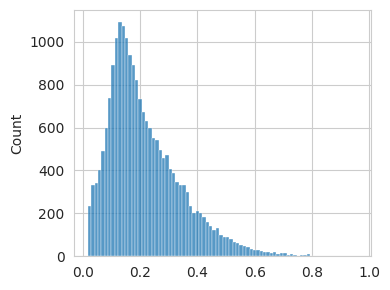

In [43]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(tqf_es.ravel(), ax=ax)
plt.tight_layout()

In [47]:
%%time
ym = run_TQF(C=5, n_jobs=4, return_model=True)

CPU times: total: 3min 31s
Wall time: 1min 10s


In [72]:
%%time
IDX = 400
w_opt, points = ym[1].predict(seed=2, x=ym[0][0][IDX],
                              n_qs=30, n_directions=20, n_ensemble=20,
                              n_jobs=5, patience=10)

Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 1170, selection rate: 58.5 %
CPU times: total: 7.09 s
Wall time: 9.82 s


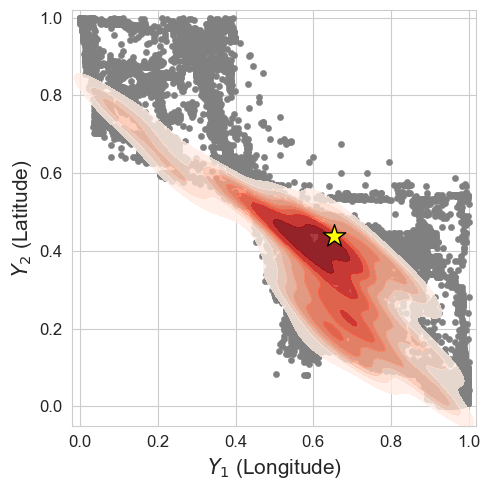

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(Y, x='Longitude', y='Latitude', s=20, color=(0.5, 0.5, 0.5), ax=ax, edgecolor=None)

IDX = 400
# ground truth
plt.scatter(ym[0][1][IDX, 0], ym[0][1][IDX, 1], marker='*', s=290, c='yellow', 
            edgecolor='k', zorder=3)
# ensemble prediction
sns.kdeplot(data=pd.DataFrame(points), x=0, y=1, weights=w_opt, cmap='Reds', 
            levels=9, fill=True, alpha=0.8, thresh=0.1)

ax.set_xlabel(r'$Y_1$ (Longitude)', fontsize=15)
ax.set_ylabel(r'$Y_2$ (Latitude)', fontsize=15)
ax.set_xlim(-0.02, 1.02); ax.set_ylim(-0.05, 1.02)
plt.tick_params(labelsize=12)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
# plt.savefig('fg_housing_tqf.pdf', dpi=400)

# KNN

In [121]:
from sklearn.preprocessing import StandardScaler
X_SS = StandardScaler().set_output(transform='pandas').fit_transform(df[['MedHouseVal', 'AveOccup']])
X_SS.shape

(20640, 2)

In [ ]:
def run_KNN(C: int, n_neighbor: int, return_ypreds_for_given_index: int | bool = False):

    if isinstance(return_ypreds_for_given_index, bool):
        assert return_ypreds_for_given_index == False

    assert C in range(n_cv)
    assert n_neighbor > 1
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X_SS.values[trainval_idx]
    Y_tv = Y.values[trainval_idx]
    X_test = X_SS.values[test_idx]
    Y_test = Y.values[test_idx]
    
    from scipy.spatial import KDTree
    nn = KDTree(data=X_tv).query(X_test, k=n_neighbor)[1]
    assert nn.shape == (len(X_test), n_neighbor)
    Y_pred_mean = []
    es = []

    for i in range(len(X_test)):

        zs = Y_tv[nn[i]]
        Y_pred_mean.append(np.mean(zs, axis=0))
        y_true = Y_test[i]
        es.append(energy_score(y=y_true, zs=zs))

        if not isinstance(return_ypreds_for_given_index, bool):
            
            if i == return_ypreds_for_given_index:
                y_preds = zs.copy()

    Y_pred_mean = np.array(Y_pred_mean)
    es = np.array(es)

    if return_ypreds_for_given_index == False:
        return Y_test, Y_pred_mean, es
    else:
        return Y_test, Y_pred_mean, es, y_preds

In [123]:
%%time
for NN in [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500]:
    
    _out_all_knn = [run_KNN(C=C, n_neighbor=NN) for C in range(n_cv)]
    from sklearn.metrics import r2_score
    print(NN, '\t', np.array([r2_score(y_true=out[0], y_pred=out[1]) for out in _out_all_knn]).mean())

5 	 -0.07545677423477173
10 	 0.011115199327468872
20 	 0.06309005916118622
30 	 0.07811547517776489
40 	 0.0842817634344101
50 	 0.08733109533786773
60 	 0.08928197920322418
70 	 0.09127964973449706
80 	 0.09267557561397552
90 	 0.09322328865528107
100 	 0.09396830499172211
200 	 0.09310530722141266
300 	 0.09182671904563904
400 	 0.09044868350028992
500 	 0.08820931017398834
CPU times: user 59.9 s, sys: 30.8 ms, total: 59.9 s
Wall time: 59.9 s


In [124]:
%%time
out_all_knn = [run_KNN(C=C, n_neighbor=100) for C in range(n_cv)]

CPU times: user 2.17 s, sys: 0 ns, total: 2.17 s
Wall time: 2.17 s


In [125]:
from sklearn.metrics import r2_score
knn_r2 = np.array([r2_score(y_true=out[0], y_pred=out[1],
                            multioutput='raw_values') for out in out_all_knn])
knn_r2

array([[0.08295578, 0.14492351],
       [0.06330788, 0.11848229],
       [0.06139714, 0.11135721],
       [0.06863862, 0.1247986 ],
       [0.05514812, 0.10767925],
       [0.05685133, 0.12834626],
       [0.0516187 , 0.1132645 ],
       [0.07263541, 0.13099414],
       [0.06794059, 0.11526656],
       [0.07937759, 0.12438262]], dtype=float32)

In [126]:
knn_r2.mean(axis=0), knn_r2.std(axis=0)

(array([0.06598712, 0.12194949], dtype=float32),
 array([0.00978739, 0.01054759], dtype=float32))

In [128]:
knn_r2.mean(axis=1).mean(), knn_r2.mean(axis=1).std()

(0.09396831, 0.009463631)

In [129]:
knn_es = np.array([out[2] for out in out_all_knn])
knn_es.shape

(10, 2064)

In [134]:
knn_es.mean(), knn_es.std(), np.median(knn_es)

(0.22115901926692447, 0.11759774753426044, 0.19507443482936343)

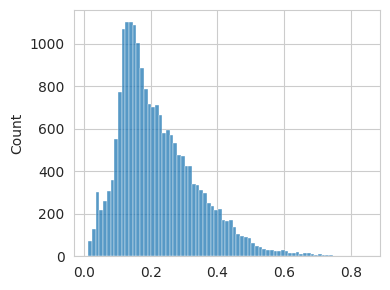

In [133]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(knn_es.ravel(), ax=ax)
plt.tight_layout()

In [136]:
%%time
IDX = 400
out5 = run_KNN(C=5, n_neighbor=100, return_ypreds_for_given_index=IDX)

CPU times: user 218 ms, sys: 0 ns, total: 218 ms
Wall time: 217 ms


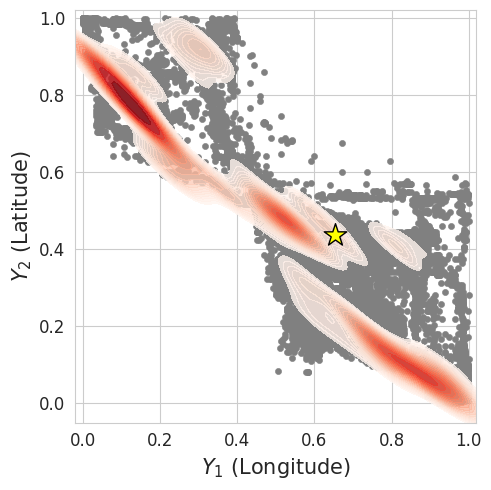

In [148]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(Y, x='Longitude', y='Latitude', s=20, color=(0.5, 0.5, 0.5), ax=ax, edgecolor=None)

# ground truth
plt.scatter(out5[0][IDX, 0], out5[0][IDX, 1], marker='*', s=290, c='yellow', 
            edgecolor='k', zorder=3)

sns.kdeplot(data=pd.DataFrame(out5[3]), x=0, y=1, cmap='Reds', levels=22, fill=True, alpha=0.8, thresh=0.2, bw_adjust=0.4)

ax.set_xlabel(r'$Y_1$ (Longitude)', fontsize=15)
ax.set_ylabel(r'$Y_2$ (Latitude)', fontsize=15)
ax.set_xlim(-0.02, 1.02); ax.set_ylim(-0.05, 1.02)
plt.tick_params(labelsize=12)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
# plt.savefig('fg_housing_knn.pdf', dpi=400)

# Trivial prediction

In [86]:
def run_Trivial(C: int, n_jobs: int):

    assert C in range(n_cv)
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X.values[trainval_idx]
    Y_tv = Y.values[trainval_idx]
    X_test = X.values[test_idx]
    Y_test = Y.values[test_idx]
    
    Y_pred = np.array([Y_tv.mean(axis=0)] * len(X_test))
    es = []

    from scipy.spatial.distance import pdist
    interdist_Y = pdist(Y_tv).mean()

    def aux(i: int):
        # return energy_score(y=Y_test[i], zs=Y_tv)
        return 0.5 * energy_distance(X=np.atleast_2d(Y_test[i]), Y=Y_tv, interdist_Y=interdist_Y) ** 2

    from joblib import Parallel, delayed
    es = Parallel(n_jobs=n_jobs)(delayed(aux)(i) for i in range(len(X_test)))
    es = np.array(es)

    return Y_test, Y_pred, es

In [87]:
%%time
out_triv = [run_Trivial(C=C, n_jobs=5) for C in range(n_cv)]

CPU times: user 12.3 s, sys: 5.2 s, total: 17.5 s
Wall time: 38.2 s


In [88]:
from sklearn.metrics import r2_score
triv_r2 = np.array([r2_score(y_true=out[0], y_pred=out[1],
                             multioutput='raw_values') for out in out_triv])
triv_r2

array([[-0.00017631, -0.00004566],
       [-0.00183773, -0.00111318],
       [-0.00013208, -0.00035667],
       [-0.00012529, -0.00001872],
       [-0.00024211, -0.00017464],
       [-0.0002501 , -0.00030327],
       [-0.00111639, -0.00033545],
       [-0.00020325, -0.00005138],
       [-0.00066471, -0.00005162],
       [-0.00021112, -0.00010157]], dtype=float32)

In [89]:
triv_r2.mean(axis=0), triv_r2.std(axis=0)

(array([-0.00049591, -0.00025522], dtype=float32),
 array([0.00053642, 0.00031114], dtype=float32))

In [132]:
triv_r2.mean(axis=1).mean(), triv_r2.mean(axis=1).std()

(np.float32(-0.0003755629), np.float32(0.00040738034))

In [91]:
triv_es = np.array([out[2] for out in out_triv])
triv_es.shape

(10, 2064)

In [94]:
triv_es.mean(), triv_es.std(), np.median(triv_es)

(0.24439231044053528, 0.09040530089092014, 0.23544019975953118)

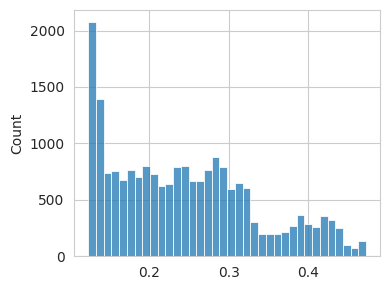

In [95]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(triv_es.ravel(), ax=ax)
plt.tight_layout()

# NGBoost

In [10]:
from ngboost import NGBRegressor
from ngboost.distns import MultivariateNormal
from sklearn.tree import DecisionTreeRegressor

In [17]:
def para_search_NGB(C: int):

    assert C in range(n_cv)
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X.values[trainval_idx]
    Y_tv = Y.values[trainval_idx]
    from sklearn.model_selection import train_test_split
    X_train, X_val, Y_train, Y_val = train_test_split(X_tv, Y_tv, test_size=len(test_idx), random_state=C)

    from sklearn.metrics import r2_score
    import gc
    res = []
    model = None

    for lr in [0.01, 0.02, 0.05, 0.1, 0.2]:
        for msl in [5, 10, 20, 50, 100, 200, 300]:
            
            if model is not None:
                del model
                gc.collect()

            print({'learning_rate': lr, 'min_samples_leaf': msl}, end=' ')
            model = NGBRegressor(Base=DecisionTreeRegressor(min_samples_leaf=msl, max_depth=None, random_state=None), 
                                 Dist=MultivariateNormal(2), random_state=C, verbose=False, n_estimators=1000,
                                 early_stopping_rounds=10, learning_rate=lr)
            model.fit(X_train, Y_train)
            print({'best_iter': model.best_val_loss_itr})
            Y_pred = model.predict(X_val)
            R2 = r2_score(y_true=Y_val, y_pred=Y_pred)
            res.append({'learning_rate': lr, 'min_samples_leaf': msl, 'R2': R2})
    return res

In [18]:
%%time
para_NGB_result = para_search_NGB(C=0)

{'learning_rate': 0.01, 'min_samples_leaf': 5} early_stopping_rounds is set to 10 but no validation set is provided creating val set with 0.1 of the training data
Creating validation set without sample weight similar to the training data
{'best_iter': 116}
{'learning_rate': 0.01, 'min_samples_leaf': 10} early_stopping_rounds is set to 10 but no validation set is provided creating val set with 0.1 of the training data
Creating validation set without sample weight similar to the training data
{'best_iter': 176}
{'learning_rate': 0.01, 'min_samples_leaf': 20} early_stopping_rounds is set to 10 but no validation set is provided creating val set with 0.1 of the training data
Creating validation set without sample weight similar to the training data
{'best_iter': 241}
{'learning_rate': 0.01, 'min_samples_leaf': 50} early_stopping_rounds is set to 10 but no validation set is provided creating val set with 0.1 of the training data
Creating validation set without sample weight similar to the tr

In [20]:
[para_NGB_result[i] for i in np.argsort([o['R2'] for o in para_NGB_result])[::-1]]

[{'learning_rate': 0.1, 'min_samples_leaf': 100, 'R2': 0.18112330654874176},
 {'learning_rate': 0.05, 'min_samples_leaf': 200, 'R2': 0.18087682434756103},
 {'learning_rate': 0.01, 'min_samples_leaf': 200, 'R2': 0.18029757058014506},
 {'learning_rate': 0.1, 'min_samples_leaf': 50, 'R2': 0.17980843716716066},
 {'learning_rate': 0.05, 'min_samples_leaf': 100, 'R2': 0.17964900273228024},
 {'learning_rate': 0.02, 'min_samples_leaf': 100, 'R2': 0.17952765880646115},
 {'learning_rate': 0.05, 'min_samples_leaf': 300, 'R2': 0.17939339723554298},
 {'learning_rate': 0.01, 'min_samples_leaf': 100, 'R2': 0.17933719003726611},
 {'learning_rate': 0.1, 'min_samples_leaf': 300, 'R2': 0.17902655977986986},
 {'learning_rate': 0.02, 'min_samples_leaf': 50, 'R2': 0.1789770045843943},
 {'learning_rate': 0.02, 'min_samples_leaf': 200, 'R2': 0.17894754993831036},
 {'learning_rate': 0.01, 'min_samples_leaf': 300, 'R2': 0.1788512058543269},
 {'learning_rate': 0.05, 'min_samples_leaf': 50, 'R2': 0.17847406006910

In [ ]:
def run_NGB(C: int, n_jobs: int, return_ypreds_for_given_index: int | bool):

    if isinstance(return_ypreds_for_given_index, bool):
        assert return_ypreds_for_given_index == False
        
    assert C in range(n_cv)
    trainval_idx, test_idx = cv_indices_list[C]
    X_tv = X.values[trainval_idx]
    Y_tv = Y.values[trainval_idx]
    X_test = X.values[test_idx]
    Y_test = Y.values[test_idx]

    from sklearn.metrics import r2_score
    lr = 0.1
    msl = 100
    model = NGBRegressor(Base=DecisionTreeRegressor(min_samples_leaf=msl, max_depth=None, random_state=None), 
                         Dist=MultivariateNormal(2), random_state=C, verbose=False, n_estimators=1000,
                         early_stopping_rounds=10, learning_rate=lr)
    model.fit(X_tv, Y_tv)

    if not isinstance(return_ypreds_for_given_index, bool):
    
        np.random.seed(C)
        _zs = np.array(model.pred_dist(X_test[return_ypreds_for_given_index: 
              return_ypreds_for_given_index + 1]).rvs(10000)).squeeze()
        
        return Y_test[return_ypreds_for_given_index], _zs
    
    else:
        Y_pred = model.predict(X_test)
        
        def aux(i: int) -> float:
            
            np.random.seed(i)
            _zs = np.array(model.pred_dist(X_test[i: i + 1]).rvs(1000)).squeeze()
            
            return energy_score(y=Y_test[i], zs=_zs)

        es = np.array(Parallel(n_jobs=n_jobs)(delayed(aux)(i) for i in range(len(X_test)))).squeeze()
        
        return Y_test, Y_pred, es

In [46]:
%%time
out_ngb = [run_NGB(C=C, n_jobs=5, return_ypreds_for_given_index=False) for C in range(n_cv)]

early_stopping_rounds is set to 10 but no validation set is provided creating val set with 0.1 of the training data
Creating validation set without sample weight similar to the training data
early_stopping_rounds is set to 10 but no validation set is provided creating val set with 0.1 of the training data
Creating validation set without sample weight similar to the training data
early_stopping_rounds is set to 10 but no validation set is provided creating val set with 0.1 of the training data
Creating validation set without sample weight similar to the training data
early_stopping_rounds is set to 10 but no validation set is provided creating val set with 0.1 of the training data
Creating validation set without sample weight similar to the training data
early_stopping_rounds is set to 10 but no validation set is provided creating val set with 0.1 of the training data
Creating validation set without sample weight similar to the training data
early_stopping_rounds is set to 10 but no val

In [64]:
import dill
with open('housing_NGB_cv.pkl', 'wb') as f:
    dill.dump(out_ngb, f)

In [8]:
import dill
# with open('housing_NGB_cv.pkl', 'rb') as f:
with open('saved_outputs/housing_NGB_cv.pkl', 'rb') as f:
    out_ngb = dill.load(f)

In [47]:
from sklearn.metrics import r2_score
ngb_r2 = np.array([r2_score(y_true=out[0], y_pred=out[1], multioutput='raw_values') for out in out_ngb])
ngb_r2

array([[0.14723248, 0.21796454],
       [0.15632057, 0.23391685],
       [0.14770486, 0.229682  ],
       [0.16580992, 0.23090587],
       [0.15259654, 0.21844034],
       [0.14261959, 0.2208636 ],
       [0.16584602, 0.23217698],
       [0.16852109, 0.24005861],
       [0.16259902, 0.2206939 ],
       [0.16187993, 0.2067278 ]])

In [51]:
ngb_r2.mean(axis=0), ngb_r2.std(axis=0)

(array([0.157113  , 0.22514305]), array([0.00867231, 0.00936178]))

In [52]:
ngb_r2.mean(axis=1).mean(), ngb_r2.mean(axis=1).std()

(np.float64(0.19112802630888132), np.float64(0.0074072237032080076))

In [10]:
ngb_es = np.array([out[2] for out in out_ngb])
ngb_es.shape

(10, 2064)

In [58]:
ngb_es.mean(), ngb_es.std(), np.median(ngb_es)

(np.float64(0.21499271164023512),
 np.float64(0.12204135054062713),
 np.float64(0.18769296850471137))

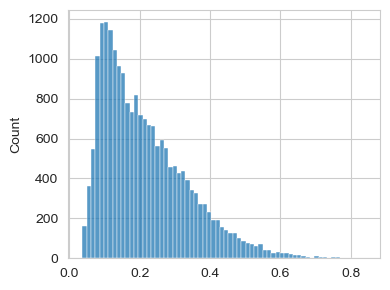

In [59]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.histplot(ngb_es.ravel(), ax=ax)
plt.tight_layout()

In [60]:
%%time
IDX = 400
outngb5 = run_NGB(C=5, n_jobs=1, return_ypreds_for_given_index=IDX)

early_stopping_rounds is set to 10 but no validation set is provided creating val set with 0.1 of the training data
Creating validation set without sample weight similar to the training data
CPU times: total: 47.3 s
Wall time: 47.8 s


In [61]:
outngb5[0].shape, outngb5[1].shape

((2,), (10000, 2))

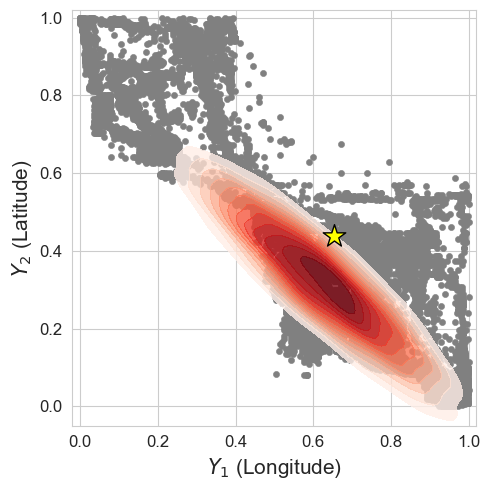

In [63]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(Y, x='Longitude', y='Latitude', s=20, color=(0.5, 0.5, 0.5), ax=ax, edgecolor=None)

# ground truth
plt.scatter(outngb5[0][0], outngb5[0][1], marker='*', s=290, c='yellow', 
            edgecolor='k', zorder=3)

sns.kdeplot(data=pd.DataFrame(outngb5[1]), x=0, y=1, cmap='Reds', levels=13, fill=True, alpha=0.8, thresh=0.2)

ax.set_xlabel(r'$Y_1$ (Longitude)', fontsize=15)
ax.set_ylabel(r'$Y_2$ (Latitude)', fontsize=15)
ax.set_xlim(-0.02, 1.02); ax.set_ylim(-0.05, 1.02)
plt.tick_params(labelsize=12)
ax.set_aspect('equal', adjustable='box')
plt.tight_layout()
# plt.savefig('fg_housing_ngb.pdf', dpi=400)

# Statistical test (TQF & NGBoost regarding ES)

In [12]:
from scipy.stats import shapiro, wilcoxon

In [ ]:
shapiro(tqf_es.ravel()), shapiro(ngb_es.ravel())

c:\Users\asuka\miniforge3\envs\boosting\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20640.
  res = hypotest_fun_out(*samples, **kwds)


(ShapiroResult(statistic=np.float64(0.9246811008682871), pvalue=np.float64(2.4850284829060903e-71)),
 ShapiroResult(statistic=np.float64(0.9205474177068519), pvalue=np.float64(1.8210281915789414e-72)))

In [14]:
wilcoxon(x=tqf_es.ravel(), y=ngb_es.ravel())

WilcoxonResult(statistic=np.float64(105852420.0), pvalue=np.float64(0.4440795944842296))